In [3]:
# imports 
import os
import time
import datetime
import json
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns

from sklearn import metrics

from itertools import product

In [4]:
dataDirectory = 'data'

In [5]:
train = pd.read_csv(dataDirectory+'/train.csv')
test = pd.read_csv(dataDirectory+'/test.csv')
sub = pd.read_csv(dataDirectory+'/sample_submission.csv')
structures = pd.read_csv(dataDirectory+'/structures.csv')

In [5]:
print('Train shape: ',train.shape)
print('Test shape: ',test.shape)
print('Structures shape: ',structures.shape)

Train shape:  (4658147, 6)
Test shape:  (2505542, 5)
Structures shape:  (2358657, 6)


In [6]:
train.head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548


In [7]:
structures.head(3)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277


In [7]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {structures['atom'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 5 unique atoms.
There are 8 unique types.


In [8]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,2.329073e+06,1.335689e+01,5.883966e+00,1.592165e+01
std,1.344691e+06,3.267712e+00,4.993943e+00,3.494198e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.549780e-01
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281130e+00
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390655e+00
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048800e+02


In [9]:
structures.describe()

,atom_index,x,y,z
count,2.358657e+06,2.358657e+06,2.358657e+06,2.358657e+06
mean,8.757349e+00,9.489178e-02,-3.337381e-01,6.241504e-02
std,5.592487e+00,1.655271e+00,1.989152e+00,1.445870e+00
min,0.000000e+00,-9.234889e+00,-9.933938e+00,-9.134765e+00
25%,4.000000e+00,-8.746097e-01,-1.826156e+00,-8.424896e-01
50%,9.000000e+00,5.183615e-02,-4.035932e-01,1.093207e-02
75%,1.300000e+01,1.116101e+00,1.373660e+00,9.394357e-01
max,2.800000e+01,9.382240e+00,1.018196e+01,7.894733e+00


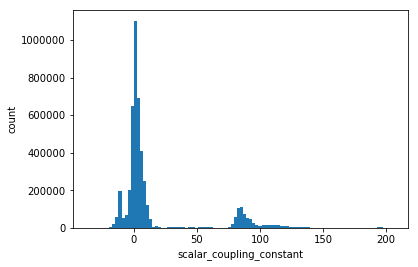

In [11]:
plt.hist(train.scalar_coupling_constant,bins=100)
plt.xlabel('scalar_coupling_constant')
plt.ylabel('count')

#### It is interesting to note that there are atleast two/three distinct gaussian distributions in the data. The distributions of coupling constant may be conditioned on one of the variables. Lets explore.

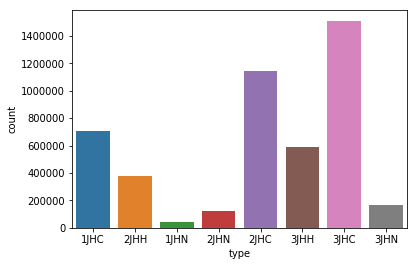

In [11]:
sns.countplot(x="type", data=train)

#### There is unequal distribution of the coupling types

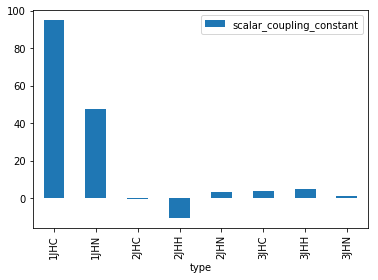

In [12]:
train[['type','scalar_coupling_constant']].groupby('type').mean().plot.bar()

#### Coupling constants central tendency show a strong rlationship with coupling type. Lets observe the entire distribution.

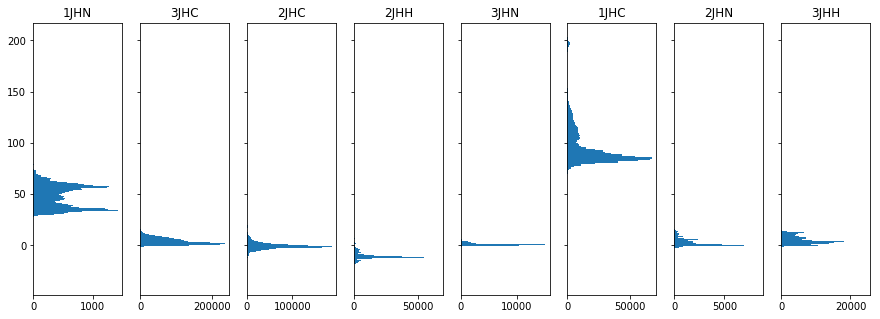

In [13]:
f, ax = plt.subplots(1, 8, sharex='col', sharey='row', figsize=(15,5))

for i,t in enumerate(set(train.type)):
    ax[i].hist(train[train.type==t].scalar_coupling_constant,orientation="horizontal", bins=100) 
    ax[i].set_title(t)

#### Conditioned on the type, coupling constant has a distinct distribution shape. 

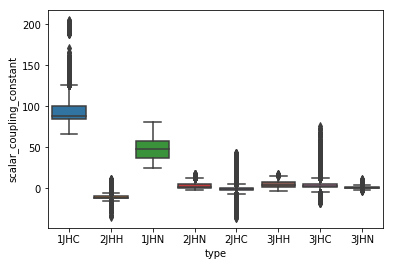

In [14]:
sns.boxplot(x='type',y='scalar_coupling_constant',data=train)

#### It is clear that each coupling type yields a distintive gausian/gaussian mixture distribution. Thus type is a strong predictor of coupling constant.

In [6]:
trainMerged = pd.merge(train, structures, how = 'left',left_on  = ['molecule_name', 'atom_index_0'],
                  right_on = ['molecule_name',  'atom_index'])
trainMerged.rename(columns={'atom': 'atom_0','x': 'x_0','y': 'y_0','z': 'z_0'}, inplace=True)


trainMerged = pd.merge(trainMerged, structures, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_1'],
                  right_on = ['molecule_name',  'atom_index'])
trainMerged.rename(columns={'atom': 'atom_1','x': 'x_1','y': 'y_1','z': 'z_1'}, inplace=True)

trainMerged.drop(['atom_index_x','atom_index_y'], axis=1, inplace=True)

trainMerged.head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.00215,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.00215,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644


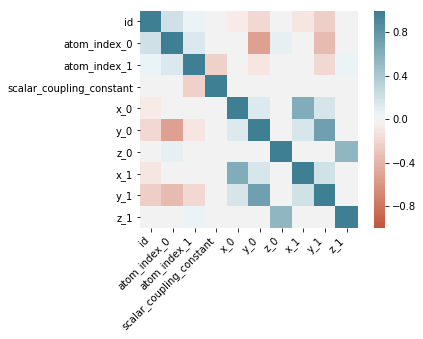

In [16]:
corr = trainMerged.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### Coupling constant does not have linear correlation with position of the atoms. Lets examine if distance rather than location shows any linear dependencies.

In [17]:
def EuclideanDistance(x,y,z):
    return np.power(x**2 + y**2 + z**2,0.5)
    
vecDist = np.vectorize(EuclideanDistance)

In [18]:
trainMerged['RelPos_x'] = np.abs(trainMerged['x_0'] - trainMerged['x_1'])
trainMerged['RelPos_y'] = np.abs(trainMerged['y_0'] - trainMerged['y_1'])
trainMerged['RelPos_z'] = np.abs(trainMerged['z_0'] - trainMerged['z_1'])
trainMerged['Euc_Dist'] = vecDist(trainMerged.RelPos_x, trainMerged.RelPos_y ,trainMerged.RelPos_z)

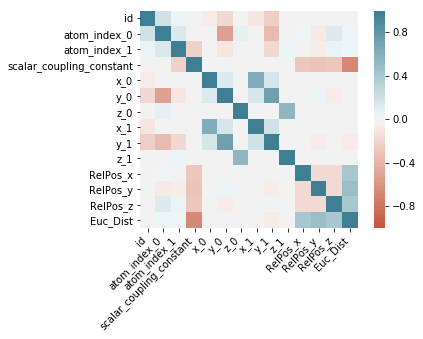

In [19]:
corr = trainMerged.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### Relative location shows weak negative correlation.
#### Euclidean distance shows strong negative correlation
#### overall there are a very few linear dependencies in the data thus thus linear regression does not seem to be a suitable modelling paradigm and we need to explore non-linear hypothesis space.

In [7]:
molecuesDf = structures[['molecule_name','atom']].groupby('molecule_name').count().reset_index()
molecuesDf.columns = ['molecule_name','atomCount']
molecuesDf.head(3)

,molecule_name,atomCount
0,dsgdb9nsd_000001,5
1,dsgdb9nsd_000002,4
2,dsgdb9nsd_000003,3


In [8]:
trainMerged = pd.merge(trainMerged, molecuesDf, how = 'left',
                  left_on  = ['molecule_name'],
                  right_on = ['molecule_name'] )
trainMerged.head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,atomCount
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,5
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.00215,-0.006031,0.001976,H,1.011731,1.463751,0.000277,5
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.00215,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,5


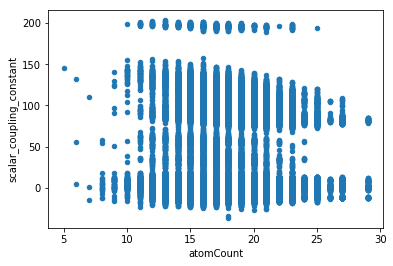

In [11]:
trainMerged.sample(frac=0.05, random_state=2019).plot(x='atomCount', y='scalar_coupling_constant', kind='scatter')

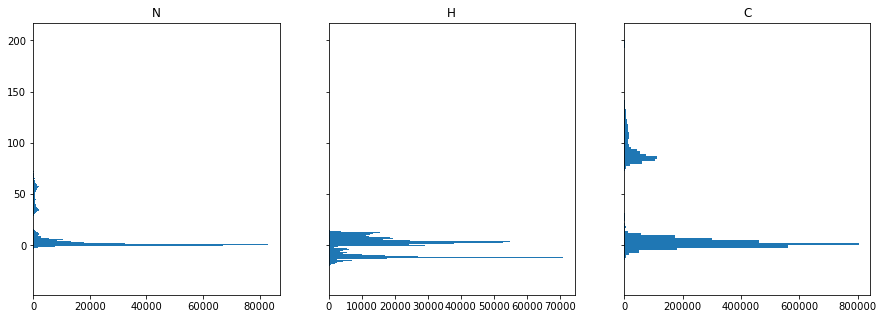

In [15]:
f, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))

for i,t in enumerate(set(trainMerged.atom_1)):
    ax[i].hist(trainMerged[trainMerged.atom_1==t].scalar_coupling_constant,orientation="horizontal", bins=100) 
    ax[i].set_title(t)

#### Atoms involved in coupling also condition the distribution of coupling coefficient.

Conclusions so far:
- Coupling type, atom type and euclidean distance are best pridictors and thus important features.
- Corelation analysis shows that there are only few weak linear dependencies and thus non-linear modeling should be preferred.
- it is intuitive to think that spatial correlations, proximities to other atoms and composition of molecule should play a role in the coupling coefficient. So thorough experiment driven feature engineering which incorporate the surrounding information of the atoms involved in feature space will improve the performance. 
- Othe ralternatives to avoiding manual feature engineering are using 3d convolutions to capture spatial relationships, or using graph convolution to capture structural relationships.